<a href="https://colab.research.google.com/github/mequanent/Social-Networks/blob/main/SN_Link_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mequanent Argaw Muluneh** \
**Social Networks Homework from Lab2 (Link Prediction)** \

**December 2022** \
\
*I did it using Colab and the tables maybe viewed better in Colab.

In [1]:
#@title Import Libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import tensorflow as tf
import pydot
import time
%matplotlib inline

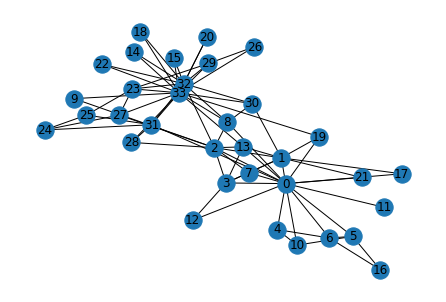

In [2]:
#@title Load the graph
G = nx.karate_club_graph()

# visualize the graph
nx.draw(G, with_labels = True)

In [ ]:
#@title Some Graph Descriptions
print("Total No. of nodes: ", G.number_of_nodes()) 
print("Total No. of edges: ", G.number_of_edges())
print(list(nx.nodes(G))) # list of nodes
print(list(G.neighbors(0))) # list of neighbors of a node, 0 for showcase

Total No. of nodes:  34
Total No. of edges:  78
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]


# Lab Practice

## Similarity Coefficients 

In [3]:
#@title Local Clustering Coefficient 

# Addition is used in the local clustering 
def get_LCC(g):
  LCC = dict()
  for i in g.nodes:
    triangles = nx.triangles(g, i)
    k = nx.degree(g, i)
    lcc = 0
    if k > 1:
      lcc = (2* triangles) /(k*(k-1))
    LCC[i] = lcc

  lccs = []
  for u in g.nodes:
    for v in g.nodes:
      if u not in nx.neighbors(g, v) and u < v:
        lccs.append((u, v, LCC[u] + LCC[v])) 
  
  return lccs 

In [4]:
#@title SimRank

# get count of neighbors for a node for |I(a)| and |I(b)|
def num_neighbors(g, a):
  neighbors = [i for i in g.neighbors(a)]
  return len(neighbors)

# find the sum of the similarity of neighbors of a and b 
def sim(g, a, b, s):
  sum = 0.0
  for i in g.neighbors(a):
    for j in g.neighbors(b):
      sum += s[i, j] 
  return sum 

def simRnk(g):
  K = 5 # maximum iterations 
  C = 0.8 # importance factor of the similarity b/n neighbors of a and b
  
  n = len(g.nodes) # number of nodes
  # initialize all simiarity values with 1.0 for a==b and 0.0 otherwise
  S = np.eye(n, dtype=np.float16) # S -> nxn similarity matrix

  for k in range(K): 
    s = S.copy() # keep the previous similarity matrix to use for the next
    for a in range(n): 
      I_a = num_neighbors(g, a) 
      for b in range(n): 
        I_b = num_neighbors(g, b) 
        if a == b:
          S[a, b] = 1.0
        elif I_a == 0 or I_b == 0: # avoid division by zero 
            S[a, b] = 0 
        else:
          S[a, b] = C  * sim(g, a, b, s)/ (I_a*I_b) 
          #simR[b, a] = simR[a, b] 
  return S  

def simRank(g):
  simR = simRnk(g)
  simRanks = []
  for u in g.nodes:
    for v in g.nodes:
      if u not in nx.neighbors(g, v) and u < v:
        simRanks.append((u, v, simR[u, v])) 
  
  return simRanks 

## Sort the coefficients 

In [5]:
#@title Edges removing function 

# This code has changed from the lab to make it function for later use
def remove_edges(graph, edgelist):
  # sort the edges to be removed in descending order
  edgelist = sorted(edgelist, reverse=True) 
  removed_edges = list()
  for i in edgelist:
      u = list(graph.edges)[i][0]
      v = list(graph.edges)[i][1]
      removed_edges.append([u,v])
      graph.remove_edge(u,v)
  return removed_edges

In [6]:
edge_to_remove = [75, 51, 18]
removed_edges = remove_edges(G, edge_to_remove)
k = len(removed_edges)

In [7]:
#@title Descending sort of Coefficients

# to avoid the same statement for all similarity coefficients 
def sort_coef(coefficient):
  return sorted(coefficient, key=lambda tup: tup[2], reverse=True)

In [8]:
#@title Get the coefficients and sort them

#@title cn, jaccard, pref_attachment, adamic 
cn = nx.common_neighbor_centrality(G) # common neighbor 
jaccard = nx.jaccard_coefficient(G) 
pref_attachment = nx.preferential_attachment(G) 
adamic = nx.adamic_adar_index(G) 
lccs =  get_LCC(G) 
simRanks = simRank(G) 
#simRanks = nx.simrank_similarity(G, source=None, target=None,
#                                 importance_factor=0.8, max_iterations=5)
#simRanks = nx.simrank_similarity(G, importance_factor=0.8)

# sort the coefficients 
cn = sort_coef(cn)
jaccard = sort_coef(jaccard)
adamic = sort_coef(adamic)
pref_attachment = sort_coef(pref_attachment)
lccs= sort_coef(lccs)
simRanks = sort_coef(simRanks)

## Evaluation Metrics

In [9]:
#@title Mean Rank (MR)
def MR(sorted_tuple, removed_edges):
  rank = 0
  idx = 0
  for u,v,val in sorted_tuple:
      if [u,v] in removed_edges:
          rank += idx
      idx += 1
  return rank/k

In [10]:
#@title Mean Reciprocal Rank (MRR)
def MRR(sorted_tuple, removed_edges):
  rank = 0
  idx = 0
  for u,v,val in sorted_tuple:
      if [u,v] in removed_edges:
          rank += 1/(idx+1) # 1/(idx +1)
      idx += 1
  return rank/k

In [11]:
#@title Hit@N
def hitN(sorted_tuple, removed_edges, N):
  hits = 0
  idx = 0
  for u,v,val in sorted_tuple:
      if [u,v] in removed_edges:
        if idx < N:
          hits += 1 
      idx += 1
  return hits

In [12]:
#@title Display Function

# display metrics and the time to compute all of them together
def display_metrics(coef, removed_edges, title, N):
  start = time.time()
  print(title)
  print("MR: ", MR(coef, removed_edges))
  print("MRR: ", MRR(coef, removed_edges))
  print(f"Hit@{N}:  {hitN(coef, removed_edges, N)}")
  end = time.time()
  print("Time %f seconds" % (end-start))
  print("\n")

In [13]:
#@title Display metrics of coefficients
# sorted_cn, sorted_jaccard, sorted_adamic, sorted_pref_attachment, sorted_lcc
display_metrics(cn, removed_edges, "Common Neighbor", 100)
display_metrics(jaccard, removed_edges, "Jaccard Coefficient", 100)
display_metrics(adamic, removed_edges, "Adamic/Adar", 100)
display_metrics(pref_attachment, removed_edges, "Preferential Attachment ", 100)
display_metrics(lccs, removed_edges, "Local Clustering Coefficient with Addition", 100)
display_metrics(simRanks, removed_edges, "SimRank", 100) 

Common Neighbor
MR:  160.0
MRR:  0.11390640802405506
Hit@100:  1
Time 0.005768 seconds


Jaccard Coefficient
MR:  184.33333333333334
MRR:  0.009301753947423238
Hit@100:  1
Time 0.002140 seconds


Adamic/Adar
MR:  131.0
MRR:  0.03173144573144573
Hit@100:  1
Time 0.003538 seconds


Preferential Attachment 
MR:  74.0
MRR:  0.029221522292215224
Hit@100:  2
Time 0.007041 seconds


Local Clustering Coefficient with Addition
MR:  370.3333333333333
MRR:  0.0032556723687336662
Hit@100:  0
Time 0.005274 seconds


SimRank
MR:  179.0
MRR:  0.006456824828917852
Hit@100:  1
Time 0.002057 seconds




# Home work

In [14]:
#@title Global variables 
metrics = ['MR', 'MRR', 'Hit@50', 'Hit@100', 'Hit@300', 'time']
coefficient_indices = ['CN', 'Jaccard', 'Pref_attachment', 'Adamic', 'LCC', 'simRanks']

In [15]:
#@title Metrics of Coefficients

def metric_of_coef(coef, m, removed_edges):
  val = 0
  if m == 'MR':
    val = MR(coef, removed_edges)
  elif m == 'MRR':
    val = MRR(coef, removed_edges) 
  elif m == 'Hit@50':
    val = hitN(coef, removed_edges, 50)
  elif m == 'Hit@100':
    val = hitN(coef, removed_edges, 100) 
  elif m == 'Hit@300':
    val = hitN(coef, removed_edges, 300)
  else:
    val = 0 
  return val

In [16]:
#@title Avg of 10 iterations for each k = {1, 5, 10, 50}

def get_coef_metrics(k):
  '''This function collects the metrics of each similarity coefficient into a 
  data frame. For every 10 iterations, it adds the metrics to their previous
  value in the data frame and then returns the average of the sum. '''
  df = pd.DataFrame(0.0, index=coefficient_indices, columns=metrics) 

  for i in range(10): 
    g = nx.karate_club_graph() # reload the graph to include the removed edges

    # generate non-repeating random integers in the range of num_egdes
    edges_to_remove = np.random.choice(range(len(g.edges)), k, replace=False)
    #edges_to_remove = [75, 51, 18]
    
    # the edges to be removed are sorted in the remove_edges() function
    removed_edges = remove_edges(g, edges_to_remove) 

    # get and sort the similarity coefficients 
    cn = sort_coef(nx.common_neighbor_centrality(g)) # common neighbor 
    jaccard = sort_coef(nx.jaccard_coefficient(g)) 
    pref_attachment = sort_coef(nx.preferential_attachment(g)) 
    adamic = sort_coef(nx.adamic_adar_index(g)) 
    lccs =  sort_coef(get_LCC(g)) 
    simRanks = sort_coef(simRank(g)) 
    
    # Map the data frame indices with the similartiy coefficient values for 
    # better use
    coefficients = {'CN': cn, 'Jaccard': jaccard, 
                    'Pref_attachment': pref_attachment, 
                    'Adamic': adamic, 'LCC': lccs, 'simRanks': simRanks}
    for i in coefficients.keys(): 
      start = time.time()
      coef = coefficients[i] # to shorten the variable name for a bit
      df.loc[i]['MR'] += metric_of_coef(coef, 'MR', removed_edges)
      df.loc[i]['MRR'] += metric_of_coef(coef, 'MRR', removed_edges)
      df.loc[i]['Hit@50'] += metric_of_coef(coef, 'Hit@50', removed_edges)
      df.loc[i]['Hit@100'] += metric_of_coef(coef, 'Hit@100', removed_edges)
      df.loc[i]['Hit@300'] += metric_of_coef(coef, 'Hit@300', removed_edges)
      df.loc[i]['time'] += time.time() - start
  return df/10 # avg will be divide by 10

In [17]:
#@title Table Formatting Function
# This function is customized from https://stackoverflow.com/a/69244857/17682341
def display_table(df, metric):
  styler = df.style.set_caption(metric).set_table_styles([{
      'selector': 'caption',
      'props': [
          ('color', 'red'),
          ('font-size', '25px'),
          ('font-style', 'italic'),
          ('font-weight', 'bold'),
          ('text-align', 'left')]
          }])
  display(styler)

In [18]:
#@title Final Get and Display
Ks = {1:'K = 1', 5:'K = 5', 10:'K = 10', 50:'K = 50'}

all_k_coef_metrics = dict() # collect values for all Ks
for k in Ks.keys(): 
  dff = get_coef_metrics(k)
  all_k_coef_metrics[k] = dff

# display the colected values in table form
for m in metrics:
  per_metric_df = pd.DataFrame(0.0, index=coefficient_indices, columns=list(Ks.values()))
  for k in Ks.keys():
    per_metric_df.loc[:, Ks[k]] = all_k_coef_metrics[k][m]
  display_table(per_metric_df, m)

,K = 1,K = 5,K = 10,K = 50
CN,171.700000,144.320000,172.600000,223.736000
Jaccard,161.900000,187.640000,200.180000,230.208000
Pref_attachment,218.500000,160.760000,154.270000,214.876000
Adamic,121.000000,121.860000,157.280000,227.366000
LCC,381.400000,382.400000,355.080000,238.684000
simRanks,131.700000,178.900000,200.830000,234.288000


,K = 1,K = 5,K = 10,K = 50
CN,0.011164,0.071843,0.097147,0.034536
Jaccard,0.008064,0.009327,0.012355,0.018929
Pref_attachment,0.034195,0.032481,0.037631,0.029816
Adamic,0.044655,0.071852,0.092929,0.037484
LCC,0.003329,0.003358,0.003423,0.023981
simRanks,0.022764,0.009181,0.013341,0.016765


,K = 1,K = 5,K = 10,K = 50
CN,0.100000,1.900000,2.500000,8.300000
Jaccard,0.000000,0.400000,1.400000,7.700000
Pref_attachment,0.400000,1.800000,3.700000,12.000000
Adamic,0.300000,2.200000,3.200000,9.000000
LCC,0.000000,0.100000,0.000000,6.100000
simRanks,0.300000,0.400000,0.600000,7.500000


,K = 1,K = 5,K = 10,K = 50
CN,0.200000,2.700000,4.100000,16.300000
Jaccard,0.300000,1.400000,2.600000,21.900000
Pref_attachment,0.400000,2.500000,4.600000,19.100000
Adamic,0.300000,2.900000,4.700000,21.900000
LCC,0.100000,0.200000,0.300000,13.900000
simRanks,0.400000,0.800000,1.600000,14.300000


,K = 1,K = 5,K = 10,K = 50
CN,1.000000,4.300000,8.300000,35.200000
Jaccard,1.000000,4.500000,8.500000,31.500000
Pref_attachment,0.600000,4.000000,8.400000,35.300000
Adamic,1.000000,4.500000,8.500000,31.500000
LCC,0.100000,0.800000,2.600000,34.500000
simRanks,0.900000,4.400000,8.200000,34.800000


,K = 1,K = 5,K = 10,K = 50
CN,0.001867,0.001645,0.001875,0.004907
Jaccard,0.000923,0.001186,0.001520,0.004362
Pref_attachment,0.000997,0.001262,0.001636,0.004353
Adamic,0.000959,0.001203,0.001609,0.004347
LCC,0.000977,0.001149,0.001613,0.004426
simRanks,0.000943,0.001158,0.001775,0.004402


In [19]:
#@title To See the values in each K
for k in Ks.keys(): 
  display_table(all_k_coef_metrics[k], f'For K = {k}')

,MR,MRR,Hit@50,Hit@100,Hit@300,time
CN,171.700000,0.011164,0.100000,0.200000,1.000000,0.001867
Jaccard,161.900000,0.008064,0.000000,0.300000,1.000000,0.000923
Pref_attachment,218.500000,0.034195,0.400000,0.400000,0.600000,0.000997
Adamic,121.000000,0.044655,0.300000,0.300000,1.000000,0.000959
LCC,381.400000,0.003329,0.000000,0.100000,0.100000,0.000977
simRanks,131.700000,0.022764,0.300000,0.400000,0.900000,0.000943


,MR,MRR,Hit@50,Hit@100,Hit@300,time
CN,144.320000,0.071843,1.900000,2.700000,4.300000,0.001645
Jaccard,187.640000,0.009327,0.400000,1.400000,4.500000,0.001186
Pref_attachment,160.760000,0.032481,1.800000,2.500000,4.000000,0.001262
Adamic,121.860000,0.071852,2.200000,2.900000,4.500000,0.001203
LCC,382.400000,0.003358,0.100000,0.200000,0.800000,0.001149
simRanks,178.900000,0.009181,0.400000,0.800000,4.400000,0.001158


,MR,MRR,Hit@50,Hit@100,Hit@300,time
CN,172.600000,0.097147,2.500000,4.100000,8.300000,0.001875
Jaccard,200.180000,0.012355,1.400000,2.600000,8.500000,0.001520
Pref_attachment,154.270000,0.037631,3.700000,4.600000,8.400000,0.001636
Adamic,157.280000,0.092929,3.200000,4.700000,8.500000,0.001609
LCC,355.080000,0.003423,0.000000,0.300000,2.600000,0.001613
simRanks,200.830000,0.013341,0.600000,1.600000,8.200000,0.001775


,MR,MRR,Hit@50,Hit@100,Hit@300,time
CN,223.736000,0.034536,8.300000,16.300000,35.200000,0.004907
Jaccard,230.208000,0.018929,7.700000,21.900000,31.500000,0.004362
Pref_attachment,214.876000,0.029816,12.000000,19.100000,35.300000,0.004353
Adamic,227.366000,0.037484,9.000000,21.900000,31.500000,0.004347
LCC,238.684000,0.023981,6.100000,13.900000,34.500000,0.004426
simRanks,234.288000,0.016765,7.500000,14.300000,34.800000,0.004402


# Appendix

Keeping some trails until submission in case looking back them may be important. 

In [ ]:
#@title Display for each K, working
k_vals = [1, 5, 10, 50] 
for k in k_vals: 
  dff = get_coef_metrics(k)
  display_table(dff, f'For K = {str(k)}')

In [ ]:
#@title Working Trail

k_vals = [1, 5, 10, 50] 
for k in k_vals: 
  g = nx.karate_club_graph() # reload the graph to include the removed edges

  # generate non-repeating random integers in the range of num_egdes
  edges_to_remove = np.random.choice(range(len(g.edges)), k, replace=False)
  print(f"Random edges removed for K = {k}: ", edges_to_remove)
  removed_edges = remove_edges(g, edges_to_remove) 

  cn = nx.common_neighbor_centrality(g) # common neighbor 
  jaccard = nx.jaccard_coefficient(g) 
  pref_attachment = nx.preferential_attachment(g) 
  adamic = nx.adamic_adar_index(g) 
  lccs =  get_LCC(g)
  simRanks = simRank(g)

  # sort the similarity coefficients  
  cn = sorted(cn, key=lambda tup: tup[2], reverse=True)
  jaccard = sorted(jaccard, key=lambda tup: tup[2], reverse=True)
  adamic = sorted(adamic, key=lambda tup: tup[2], reverse=True)
  pref_attachment = sorted(pref_attachment, key=lambda tup: tup[2], reverse=True)
  lccs = sorted(lccs, key=lambda tup: tup[2], reverse=True)
  simRanks = sorted(simRanks, key=lambda tup: tup[2], reverse=True) 
  
  print("*"*50)
  display_metrics(cn, removed_edges, "Common Neighbor", 50)
  display_metrics(jaccard, removed_edges, "Jaccard Coefficient", 50)
  display_metrics(adamic, removed_edges, "Adamic/Adar", 50)
  display_metrics(pref_attachment, removed_edges, "Preferential Attachment ", 50)
  display_metrics(lccs, removed_edges, "Local Clustering Coefficient with Addition", 50)
  display_metrics(simRanks, removed_edges, "SimRank", 50)

Random edges removed for K = 1:  [21]
**************************************************
Common Neighbor
MR:  111.0
MRR:  0.008928571428571428
Hit@50:  0
Time 0.000702 seconds


Jaccard Coefficient
MR:  223.0
MRR:  0.004464285714285714
Hit@50:  0
Time 0.000463 seconds


Adamic/Adar
MR:  139.0
MRR:  0.007142857142857143
Hit@50:  0
Time 0.000543 seconds


Preferential Attachment 
MR:  132.0
MRR:  0.007518796992481203
Hit@50:  0
Time 0.000445 seconds


Local Clustering Coefficient with Addition
MR:  452.0
MRR:  0.002207505518763797
Hit@50:  0
Time 0.000615 seconds


SimRank
MR:  216.0
MRR:  0.004608294930875576
Hit@50:  0
Time 0.017586 seconds


Random edges removed for K = 5:  [41 52 14 50 65]
**************************************************
Common Neighbor
MR:  188.2
MRR:  0.00969763144670502
Hit@50:  1
Time 0.004895 seconds


Jaccard Coefficient
MR:  226.8
MRR:  0.007855625676338804
Hit@50:  1
Time 0.000654 seconds


Adamic/Adar
MR:  172.4
MRR:  0.013830890244427546
Hit@50:  1
Time 0

In [ ]:
#@title simRank in Matrix
def simRankMatrix(g):
  adjacency_matrix = nx.to_numpy_array(g)
  s = np.array(adjacency_matrix.sum(axis=0))
  adjacency_matrix /= s
  newsim = np.eye(len(g), dtype=np.float64)

  for its in range(5): 
    prevsim = newsim.copy() 
    newsim = 0.8 * ((adjacency_matrix.T @ prevsim) @ adjacency_matrix)
    np.fill_diagonal(newsim, 1.0) 
  return newsim

def simRank(g):
  simR = simRankMatrix(g)
  simRanks = []
  for u in g.nodes:
    for v in g.nodes:
      if u not in nx.neighbors(g, v) and u < v:
        simRanks.append((u, v, simR[u, v])) 
  
  return simRanks 

In [ ]:

#@title Built-in simRank didn't converge
nx.simrank_similarity(G, importance_factor=0.8, max_iterations=5)

ExceededMaxIterations: ignored

In [ ]:
#@title Trail 3 Works!
# Works for one K values from K = [1, 5, 10, 50]
# Average of 10 iterations for a single K value. 

metrics = ['MR', 'MRR', 'Hit@50', 'Hit@100', 'Hit@300', 'time']
coefficients = ['CN', 'Jaccard', 'Pref_attachment', 'Adamic', 'LCC', 'simRanks']

df = pd.DataFrame(0.0, index=coefficients, columns = metrics) 

for i in range(10):
  k = 3
  g = nx.karate_club_graph() # reload the graph to include the removed edges

  # generate non-repeating random integers in the range of num_egdes
    #edges_to_remove = np.random.choice(range(len(g.edges)), k, replace=False)
  edges_to_remove = [75, 51, 18]
  #print(f"Random edges removed for K = {k}: ", edges_to_remove)
  removed_edges = remove_edges(g, edges_to_remove) 

  # get and sort the similarity coefficients 
  cn = sort_coef(nx.common_neighbor_centrality(g)) # common neighbor 
  jaccard = sort_coef(nx.jaccard_coefficient(g)) 
  pref_attachment = sort_coef(nx.preferential_attachment(g)) 
  adamic = sort_coef(nx.adamic_adar_index(g)) 
  lccs =  sort_coef(get_LCC(g)) 
  simRanks = sort_coef(simRank(g)) 
  #coefs = [cn, jaccard, pref_attachment, adamic, lccs, simRanks]
  #coefs = ['cn', 'jaccard', 'pref_attachment', 'adamic', 'lccs', 'simRanks']
  coefficients = {'CN': cn, 'Jaccard': jaccard, 'Pref_attachment': pref_attachment, \
           'Adamic': adamic, 'LCC': lccs, 'simRanks': simRanks}
  for i in coefficients.keys(): # ['MR', 'MRR', 'Hit@50', 'Hit@100', 'Hit@300', 'time']
    start = time.time()
    df.loc[i]['MR'] += metric_of_coef(coefficients[i], 'MR')
    df.loc[i]['MRR'] += metric_of_coef(coefficients[i], 'MRR')
    df.loc[i]['Hit@50'] += metric_of_coef(coefficients[i], 'Hit@50')
    df.loc[i]['Hit@100'] += metric_of_coef(coefficients[i], 'Hit@100')
    df.loc[i]['Hit@300'] += metric_of_coef(coefficients[i], 'Hit@300')
    df.loc[i]['time'] += time.time() - start
df/10

In [ ]:
removed_edges = list()
edgelist =  [4, 2, 24, 9, 40, 74, 38, 31, 74, 65]
#edgelist =  sorted(edgelist, reverse=True)
graph = G.copy()
edges = [list(graph.edges)[i] for i in edgelist]

for i in edgelist:
  print("current index ", i)
  print(len(graph.edges))
  u = list(graph.edges)[i][0]
  v = list(graph.edges)[i][1]
  print(u, v)
  removed_edges.append([u,v])
  graph.remove_edge(u,v)
removed_edges